# Build Linear Model for Salary Prediction

## Import Packages and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats

m_font = {'fontname':'DejaVu Sans'}

In [2]:
df = pd.read_csv('estimated_monthly_income_train.csv')
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,42,Travel_Rarely,1265,Research & Development,3,3,Life Sciences,3,Female,95,...,13,3,2,17,1,2,5,3,1,3
1,32,Non-Travel,862,Sales,2,1,Life Sciences,3,Female,76,...,12,3,3,1,3,3,1,0,0,0
2,46,Non-Travel,849,Sales,26,2,Life Sciences,2,Male,98,...,15,3,3,6,3,3,2,2,2,2
3,31,Travel_Rarely,1276,Research & Development,2,1,Medical,4,Female,59,...,11,3,3,1,4,3,1,0,0,0
4,50,Travel_Rarely,869,Sales,3,2,Marketing,1,Male,86,...,14,3,3,3,2,3,3,2,0,2


In [3]:
df.isnull().sum().any()

False

## Data Exploration

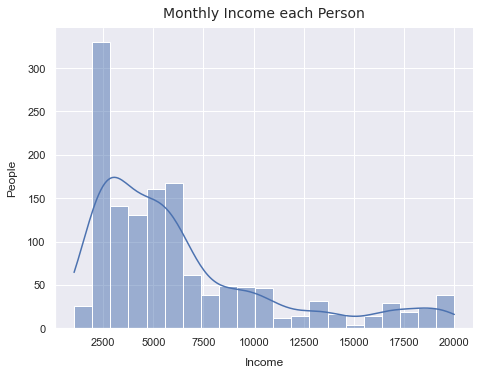

In [4]:
sns.set_theme()
sns.displot(df, x="MonthlyIncome", kde=True, height=5, aspect=1.35)
plt.title('Monthly Income each Person', fontsize=14, pad=10, **m_font)
plt.ylabel('People', labelpad=10)
plt.xlabel('Income', labelpad=10)
plt.show();

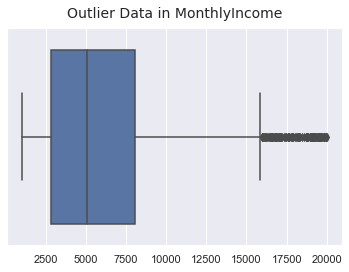

In [5]:
sns.boxplot(df["MonthlyIncome"])
plt.title('Outlier Data in MonthlyIncome', fontsize=14, pad=10, **m_font)
plt.xlabel('')
plt.show();

## Remove Outliers

In [6]:
z = np.abs(stats.zscore(df['MonthlyIncome']))
df['z_score'] = z

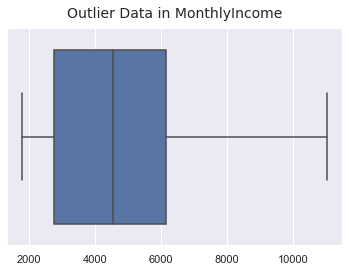

In [7]:
df_removed_outliers = df[df['z_score'] < 1]

sns.boxplot(df_removed_outliers['MonthlyIncome'])
plt.title('Outlier Data in MonthlyIncome', fontsize=14, pad=10, **m_font)
plt.xlabel('')
plt.show();

In [8]:
print(f'Total outliers removed: {df.shape[0] - df_removed_outliers.shape[0]}')
print(f'Percentage: {round((df.shape[0] - df_removed_outliers.shape[0])/df.shape[0]*100,2)}%')

Total outliers removed: 219
Percentage: 15.64%


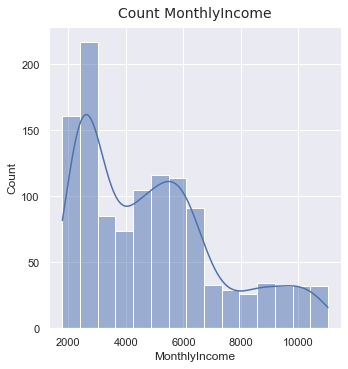

In [9]:
sns.set_theme()
sns.displot(df_removed_outliers, x="MonthlyIncome", kde=True)
plt.title('Count MonthlyIncome', fontsize=14, pad=10, **m_font)
plt.show();

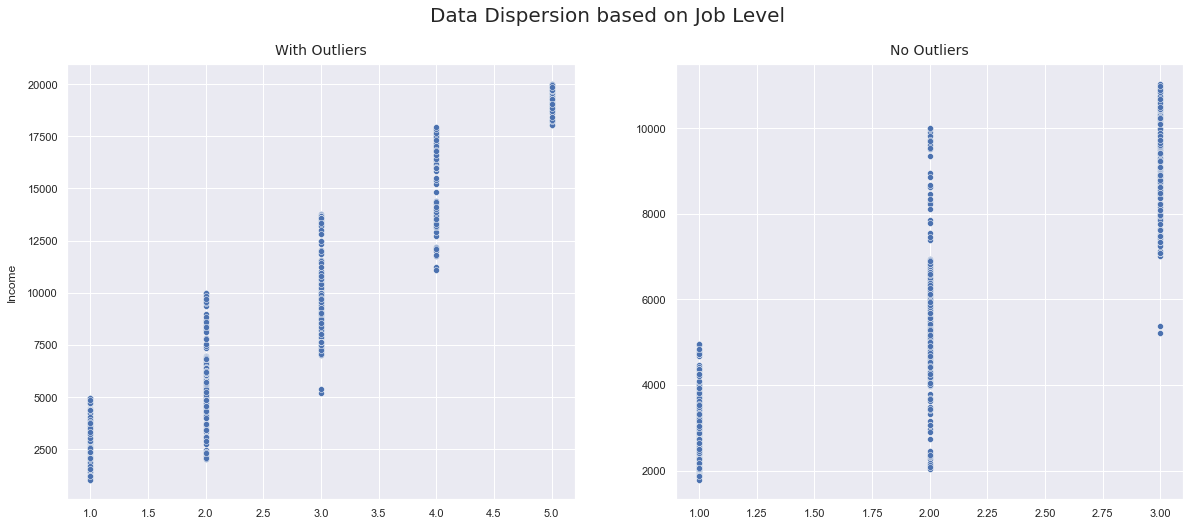

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Data Dispersion based on Job Level', fontsize=20, **m_font)
axes[0].set_title('With Outliers', fontsize=14, pad=10, **m_font)
axes[1].set_title('No Outliers', fontsize=14, pad=10, **m_font)

sns.scatterplot(ax=axes[0], 
                x="JobLevel", 
                y ="MonthlyIncome", 
                data=df.sort_values(by='JobLevel'))
sns.scatterplot(ax=axes[1], 
                x="JobLevel", 
                y ="MonthlyIncome",
                data=df_removed_outliers.sort_values(by='JobLevel'))

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[0].set_ylabel('Income', labelpad=10)
axes[1].set_ylabel('')

plt.show()

## Check Data Correlation
After plotting the data that we have cleaned from outliers, we can see that the outliers are people with high job level.

In [11]:
# Encode string data to numerical data
def encode_data(df):
    obj = df.select_dtypes('object').columns
    label = LabelEncoder()
    df[obj] = df[obj].apply(lambda x: label.fit_transform(x.str.strip()))
    return df

In [12]:
df = encode_data(df)

In [13]:
correlation = np.abs(df.corr()['MonthlyIncome']).sort_values(ascending = False).reset_index().\
    rename(columns = {'index': 'Columns', 'MonthlyIncome': 'Correlation'})

# Drop 0 for MonthlyIncome and 3 for z_score
correlation.drop([0, 3], inplace=True)

In [14]:
c1 = df['JobLevel'].value_counts()
c1 = pd.DataFrame(c1)
c1.reset_index(inplace=True)
c1.rename(columns = {'index':'JobLevel', 'JobLevel':'Count'}, inplace = True)

c2 = df_removed_outliers['JobLevel'].value_counts()
c2 = pd.DataFrame(c2)
c2.reset_index(inplace=True)
c2.rename(columns = {'index':'JobLevel', 'JobLevel':'Count'}, inplace = True)

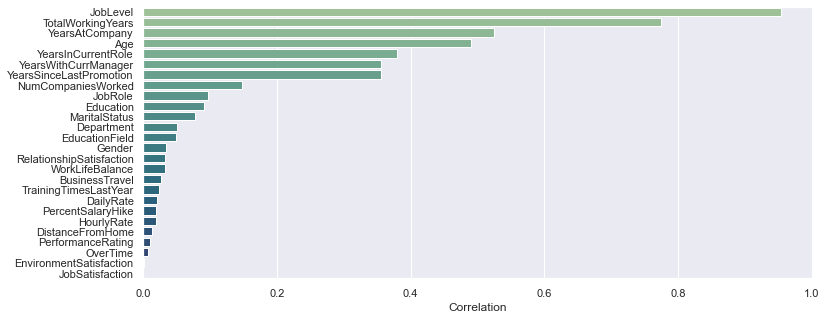

In [15]:
plt.figure(figsize=(12, 5))
sns.barplot(x=correlation["Correlation"], y=correlation["Columns"], palette="crest", data=c1, ci=None, orient = 'h')
plt.ylabel('')
plt.show()

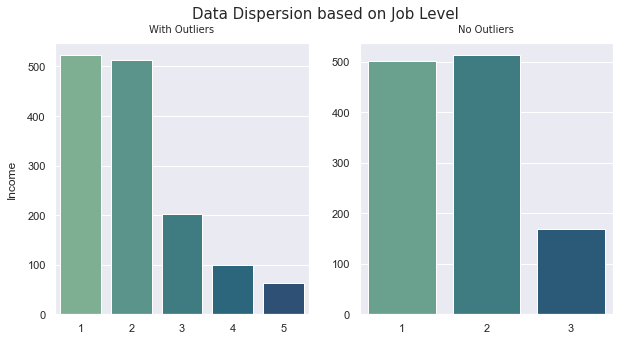

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Data Dispersion based on Job Level', fontsize=15, **m_font)
axes[0].set_title('With Outliers', fontsize=10, pad=10, **m_font)
axes[1].set_title('No Outliers', fontsize=10, pad=10, **m_font)

sns.barplot(ax=axes[0], x='JobLevel', y='Count', palette="crest", data=c1, ci=None)
sns.barplot(ax=axes[1], x='JobLevel', y='Count', palette="crest", data=c2, ci=None)

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[0].set_ylabel('Income', labelpad=10)
axes[1].set_ylabel('')

plt.show()

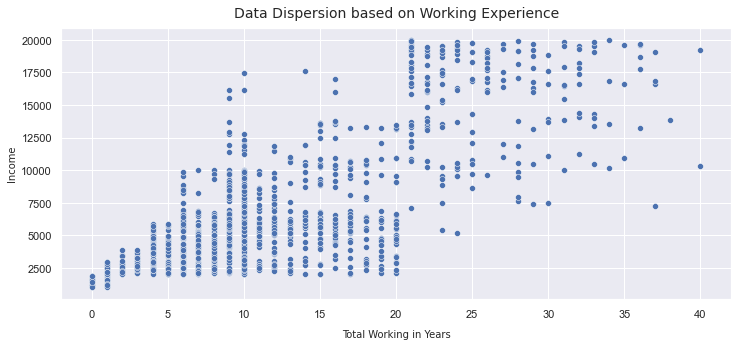

In [17]:
# Plot using data with outliers
plt.figure(figsize=(12, 5))

sns.scatterplot(x="TotalWorkingYears", y = "MonthlyIncome", palette="crest", data=df, ci=None)
plt.ylabel('Income', fontsize=10, **m_font)
plt.xlabel('Total Working in Years', fontsize=10, labelpad=10, **m_font)
plt.title('Data Dispersion based on Working Experience', fontsize=14, pad=10, **m_font)
plt.show()

## Decide Which Data to Use
To prevent our model incapability to predict people with high job level, let's create model using the default data.

In [18]:
# We use columns with correlation above 5%
chosen_col = correlation[correlation['Correlation'] > 0.05]
chosen_col = chosen_col['Columns'].to_list()

In [19]:
final_data = df[chosen_col]
final_data.head()

,JobLevel,TotalWorkingYears,YearsAtCompany,Age,YearsInCurrentRole,YearsWithCurrManager,YearsSinceLastPromotion,NumCompaniesWorked,JobRole,Education,MaritalStatus,Department
0,2,17,5,42,3,3,1,2,2,3,1,1
1,1,1,1,32,0,0,0,1,8,1,0,2
2,2,6,2,46,2,2,2,8,7,2,2,2
3,1,1,1,31,0,0,0,1,2,1,0,1
4,1,3,3,50,2,2,0,1,8,2,1,2


## Linear Regression Model Comparison to Every Different Data

### Model using All Features in our Data

In [20]:
X = df.drop(['MonthlyIncome'], axis=1)
y = df['MonthlyIncome']

In [21]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 1)

start = time.time()
model = LinearRegression()
model.fit(train_X, train_y)
end = time.time()

y_pred = model.predict(test_X)

In [22]:
r2 = []
cv = []
t = []

r2.append(round(metrics.r2_score(test_y, y_pred)*100,2))
cv.append(round(np.mean(cross_val_score(model, X, y, cv=5))*100,2))
t.append(end-start)

print('R-square predicted training :', r2[0])
print(f'Cross Validation Score      : {cv[0]}')
print(f'Time spent                  : {end-start} seconds')

R-square predicted training : 90.14
Cross Validation Score      : 93.37
Time spent                  : 0.013705015182495117 seconds


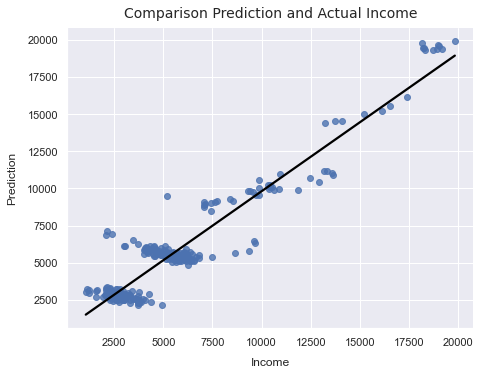

In [23]:
test = pd.DataFrame(test_y)
test['Prediction'] = y_pred

sns.lmplot(data=test, x='MonthlyIncome', y='Prediction',
           line_kws={'color': 'black'},
           height=5, aspect=1.35, ci=None)
plt.title('Comparison Prediction and Actual Income', fontsize=14, pad=10, **m_font)
plt.xlabel('Income', labelpad=10)
plt.ylabel('Prediction', labelpad=10)
plt.show()

### Model using Selected Features

In [24]:
X = final_data
y = df['MonthlyIncome']

In [25]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 1)

start = time.time()
model = LinearRegression()
model.fit(train_X, train_y)
end = time.time()

y_pred = model.predict(test_X)

In [26]:
r2.append(round(metrics.r2_score(test_y, y_pred)*100,2))
cv.append(round(np.mean(cross_val_score(model, X, y, cv=5))*100,2))
t.append(end-start)

print('R-square predicted training :', r2[1])
print(f'Cross Validation Score      : {cv[1]}')
print(f'Time spent                  : {end-start} seconds')

R-square predicted training : 87.87
Cross Validation Score      : 91.28
Time spent                  : 0.009245634078979492 seconds


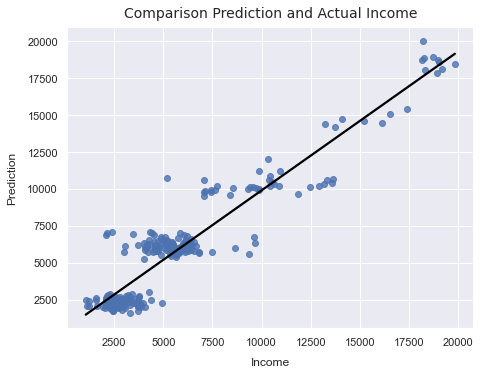

In [27]:
test = pd.DataFrame(test_y)
test['Prediction'] = y_pred

sns.lmplot(data=test, x='MonthlyIncome', y='Prediction',
           line_kws={'color': 'black'},
           height=5, aspect=1.35, ci=None)
plt.title('Comparison Prediction and Actual Income', fontsize=14, pad=10, **m_font)
plt.xlabel('Income', labelpad=10)
plt.ylabel('Prediction', labelpad=10)
plt.show()

### Model using Data without Outliers

In [28]:
df_removed_outliers = encode_data(df_removed_outliers)

In [29]:
df_removed_outliers.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'z_score'],
      dtype='object')

In [30]:
X = df_removed_outliers.drop(['MonthlyIncome', 'z_score'], axis=1)
y = df_removed_outliers['MonthlyIncome']

In [31]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 1)

start = time.time()
model = LinearRegression()
model.fit(train_X, train_y)
end = time.time()

y_pred = model.predict(test_X)

In [32]:
r2.append(round(metrics.r2_score(test_y, y_pred)*100,2))
cv.append(round(np.mean(cross_val_score(model, X, y, cv=5))*100,2))
t.append(end-start)

print('R-square predicted training :', r2[2])
print(f'Cross Validation Score      : {cv[2]}')
print(f'Time spent                  : {end-start} seconds')

R-square predicted training : 78.87
Cross Validation Score      : 79.84
Time spent                  : 0.011573314666748047 seconds


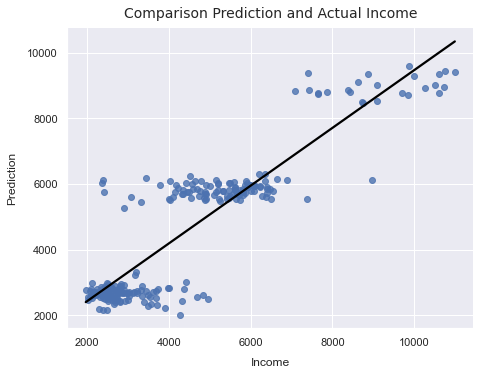

In [33]:
test = pd.DataFrame(test_y)
test['Prediction'] = y_pred

sns.lmplot(data=test, x='MonthlyIncome', y='Prediction',
           line_kws={'color': 'black'},
           height=5, aspect=1.35, ci=None)
plt.title('Comparison Prediction and Actual Income', fontsize=14, pad=10, **m_font)
plt.xlabel('Income', labelpad=10)
plt.ylabel('Prediction', labelpad=10)
plt.show()

## Results

In [34]:
result = pd.DataFrame(list(zip(r2, cv, t)),
                      columns =['R2 Score', 'Cross Val', 'Time'],
                      index=['Model with All Features', 'Model with Selected Features', 'Model with No Outliers Data'])
result

,R2 Score,Cross Val,Time
Model with All Features,90.14,93.37,0.013705
Model with Selected Features,87.87,91.28,0.009246
Model with No Outliers Data,78.87,79.84,0.011573


## Conclusion

* Model using data with removed outliers incapable to make a good decision rather than model with default data.

---

* We tried to create model using all features and ended up getting a good r2_score & cv score, but it is more efficient using selected features only. That is not a big deal since we only use small amount of data.

---

* Removing outliers in regression problem is not always the best option.